In [ ]:
!pip install pretty_midi music21 matplotlib seaborn numpy torch note-seq --quiet

import pretty_midi
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from music21 import converter, note, stream
import os
from google.colab import drive
import random
from collections import Counter
import note_seq
from note_seq.protobuf import music_pb2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 31.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_PATH = '/content/drive/MyDrive/violin'  # Update with your path
OUTPUT_MIDI = 'symbolic_unconditioned.mid'

In [ ]:
def midi_to_events(midi_file):
    try:
        sequence = note_seq.midi_file_to_note_sequence(midi_file)
        if hasattr(sequence, 'quantization_info'):
            sequence.ClearField('quantization_info')
        current_time = 0.0
        events = ["VELOCITY_100"]
        for note in sorted(sequence.notes, key=lambda n: n.start_time):
            time_shift = int((note.start_time - current_time) * 100)
            time_shift = min(time_shift, 300)
            if time_shift > 0:
                events.append(f"TIME_SHIFT_{time_shift}")
            events.append(f"NOTE_ON_{note.pitch}")
            duration = note.end_time - note.start_time
            time_shift = int(duration * 100)
            time_shift = min(time_shift, 200)
            if time_shift > 0:
                events.append(f"TIME_SHIFT_{time_shift}")
            events.append(f"NOTE_OFF_{note.pitch}")
            current_time = note.end_time
            # Normalize velocity to 60-100
            velocity = max(60, min(100, note.velocity))
            if velocity != 100:
                events.append(f"VELOCITY_{velocity}")
        return events
    except Exception as e:
        print(f"Error processing {midi_file}: {e}")
        return []

In [ ]:
def preprocess_events(data_path, max_files=116, max_seq_length=6000):
    event_sequences = []
    all_events = []
    midi_files = [os.path.join(data_path, f) for f in os.listdir(data_path) if f.endswith('.mid')]
    if not midi_files:
        raise ValueError(f"No MIDI files found in {data_path}")
    random.shuffle(midi_files)
    midi_files = midi_files[:max_files]
    failed_files = []
    for midi_file in midi_files:
        events = midi_to_events(midi_file)
        if events and len(events) <= max_seq_length:  # Filter long sequences
            event_sequences.append(events)
            all_events.extend(events)
        else:
            failed_files.append(midi_file)
    if not event_sequences:
        raise ValueError("No valid event sequences extracted. Check MIDI files for violin content.")
    event_vocab = sorted(set(all_events))
    event_to_idx = {e: i for i, e in enumerate(event_vocab)}
    sequences = [[event_to_idx[e] for e in seq] for seq in event_sequences if len(seq) >= 10]
    return sequences, event_to_idx, event_vocab

In [ ]:
sequences, event_to_idx, event_vocab = preprocess_events(DATA_PATH)
print(f"Loaded {len(sequences)} sequences")
print(f"Event vocabulary size: {len(event_vocab)}")

Loaded 111 sequences
Event vocabulary size: 449


In [ ]:
import numpy as np
from collections import Counter

print("\n=== EXPLORATORY DATA ANALYSIS ===")

# Calculate sequence length statistics
sequence_lengths = [len(seq) for seq in sequences]
all_events_flat = [event for seq in sequences for event in seq]

print(f"Sequence length statistics:")
print(f"  Mean: {np.mean(sequence_lengths):.1f}")
print(f"  Median: {np.median(sequence_lengths):.1f}")
print(f"  Min: {min(sequence_lengths)}, Max: {max(sequence_lengths)}")

# Event type analysis (unique events per type in the vocabulary)
event_types = {}
for event in event_vocab:
    event_type = event.split('_')[0] + '_' + event.split('_')[1]
    event_types[event_type] = event_types.get(event_type, 0) + 1

print(f"\nEvent type distribution:")
for event_type, count in sorted(event_types.items()):
    print(f"  {event_type}: {count} unique events")

# Extract note information for analysis
note_events = [event for event in event_vocab if event.startswith('NOTE_ON_')]
note_pitches = [int(event.split('_')[-1]) for event in note_events]

# Extract time shift information for detailed statistics
time_events = [event for event in event_vocab if event.startswith('TIME_SHIFT_')]
time_shifts = [int(event.split('_')[-1]) for event in time_events]
time_shifts_all = [int(event_vocab[event].split('_')[-1]) for event in all_events_flat if event_vocab[event].startswith('TIME_SHIFT_')]

# Extract velocity information for detailed statistics
velocity_events = [event for event in event_vocab if event.startswith('VELOCITY_')]
velocities = [int(event.split('_')[-1]) for event in velocity_events]
velocities_all = [int(event_vocab[event].split('_')[-1]) for event in all_events_flat if event_vocab[event].startswith('VELOCITY_')]

# Pitch statistics
print(f"\nPitch range: {min(note_pitches)} to {max(note_pitches)} (MIDI)")

# Most common pitches
note_on_events = [event for event in all_events_flat if event_vocab[event].startswith('NOTE_ON_')]
pitch_counts = Counter([int(event_vocab[event].split('_')[-1]) for event in note_on_events])
most_common_pitches = pitch_counts.most_common(5)  # Top 5 pitches
print("Most common pitches (MIDI number, count):")
for pitch, count in most_common_pitches:
    print(f"  Pitch {pitch}: {count} occurrences")

# Time shift statistics
print(f"\nTime shift statistics:")
print(f"  Range: {min(time_shifts)} to {max(time_shifts)} steps (0.01s/step)")
print(f"  Mean: {np.mean(time_shifts_all):.1f} steps ({np.mean(time_shifts_all)*0.01:.2f} seconds)")
print(f"  Median: {np.median(time_shifts_all):.1f} steps ({np.median(time_shifts_all)*0.01:.2f} seconds)")
print(f"  Std Dev: {np.std(time_shifts_all):.1f} steps ({np.std(time_shifts_all)*0.01:.2f} seconds)")

# Velocity statistics
print(f"\nVelocity statistics:")
print(f"  Range: {min(velocities)} to {max(velocities)} (MIDI)")
print(f"  Mean: {np.mean(velocities_all):.1f}")
print(f"  Median: {np.median(velocities_all):.1f}")
print(f"  Std Dev: {np.std(velocities_all):.1f}")


=== EXPLORATORY DATA ANALYSIS ===
Sequence length statistics:
  Mean: 1321.3
  Median: 1030.0
  Min: 56, Max: 3952

Event type distribution:
  NOTE_OFF: 82 unique events
  NOTE_ON: 82 unique events
  TIME_SHIFT: 244 unique events
  VELOCITY_100: 1 unique events
  VELOCITY_60: 1 unique events
  VELOCITY_61: 1 unique events
  VELOCITY_62: 1 unique events
  VELOCITY_63: 1 unique events
  VELOCITY_64: 1 unique events
  VELOCITY_65: 1 unique events
  VELOCITY_66: 1 unique events
  VELOCITY_67: 1 unique events
  VELOCITY_68: 1 unique events
  VELOCITY_69: 1 unique events
  VELOCITY_70: 1 unique events
  VELOCITY_71: 1 unique events
  VELOCITY_72: 1 unique events
  VELOCITY_73: 1 unique events
  VELOCITY_74: 1 unique events
  VELOCITY_75: 1 unique events
  VELOCITY_76: 1 unique events
  VELOCITY_77: 1 unique events
  VELOCITY_78: 1 unique events
  VELOCITY_79: 1 unique events
  VELOCITY_80: 1 unique events
  VELOCITY_81: 1 unique events
  VELOCITY_82: 1 unique events
  VELOCITY_83: 1 unique 

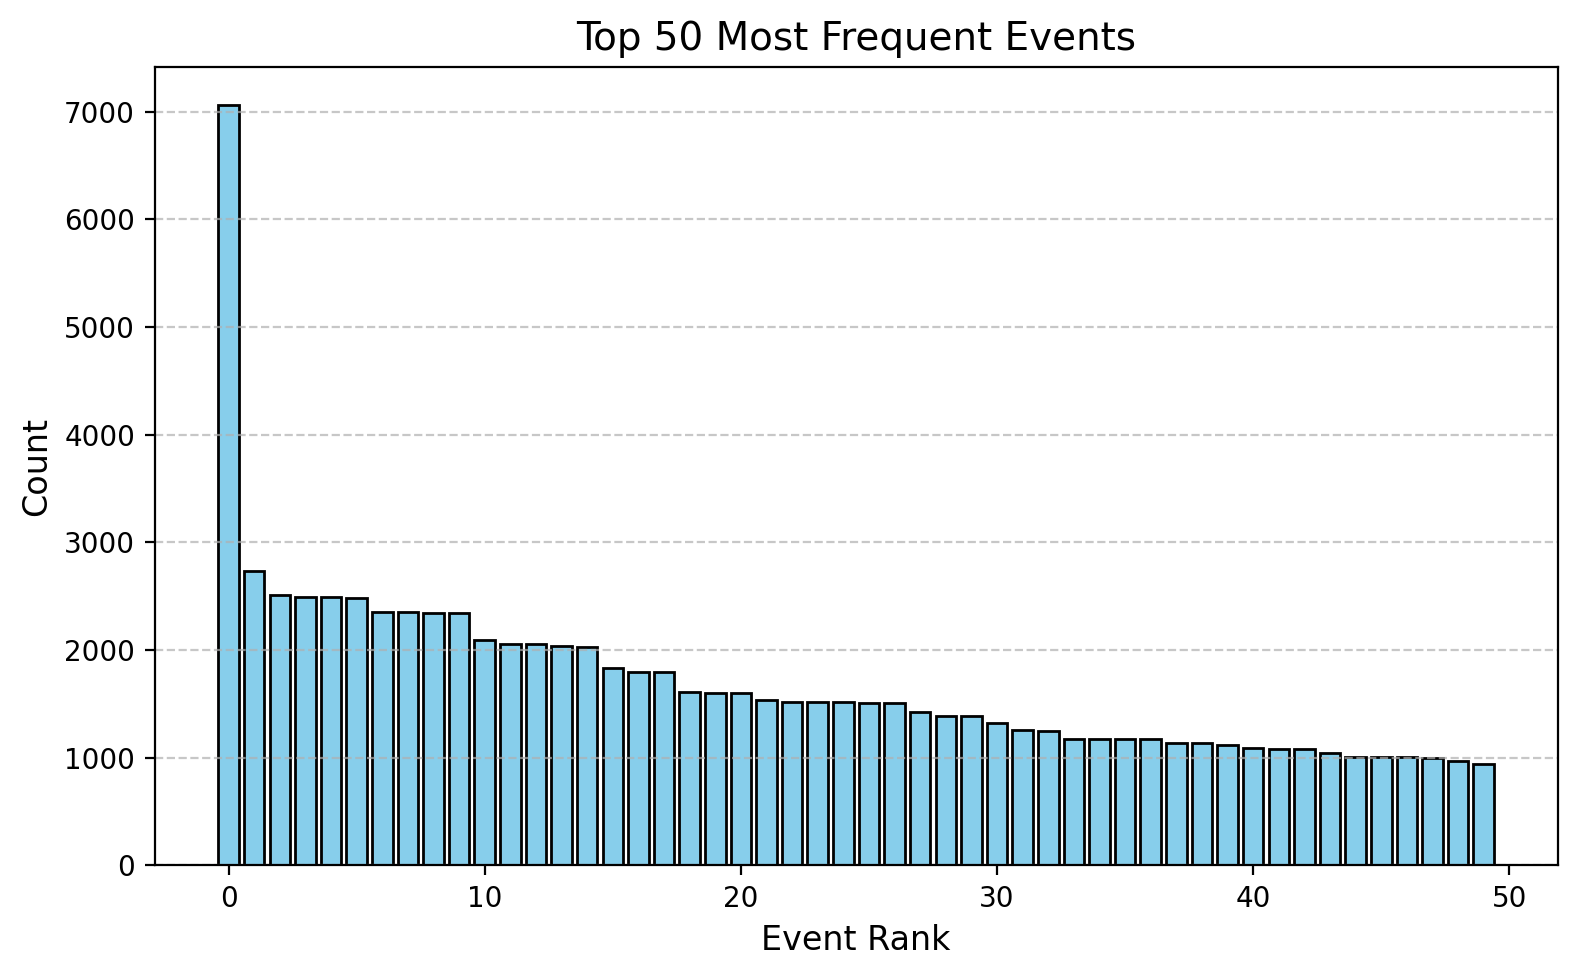

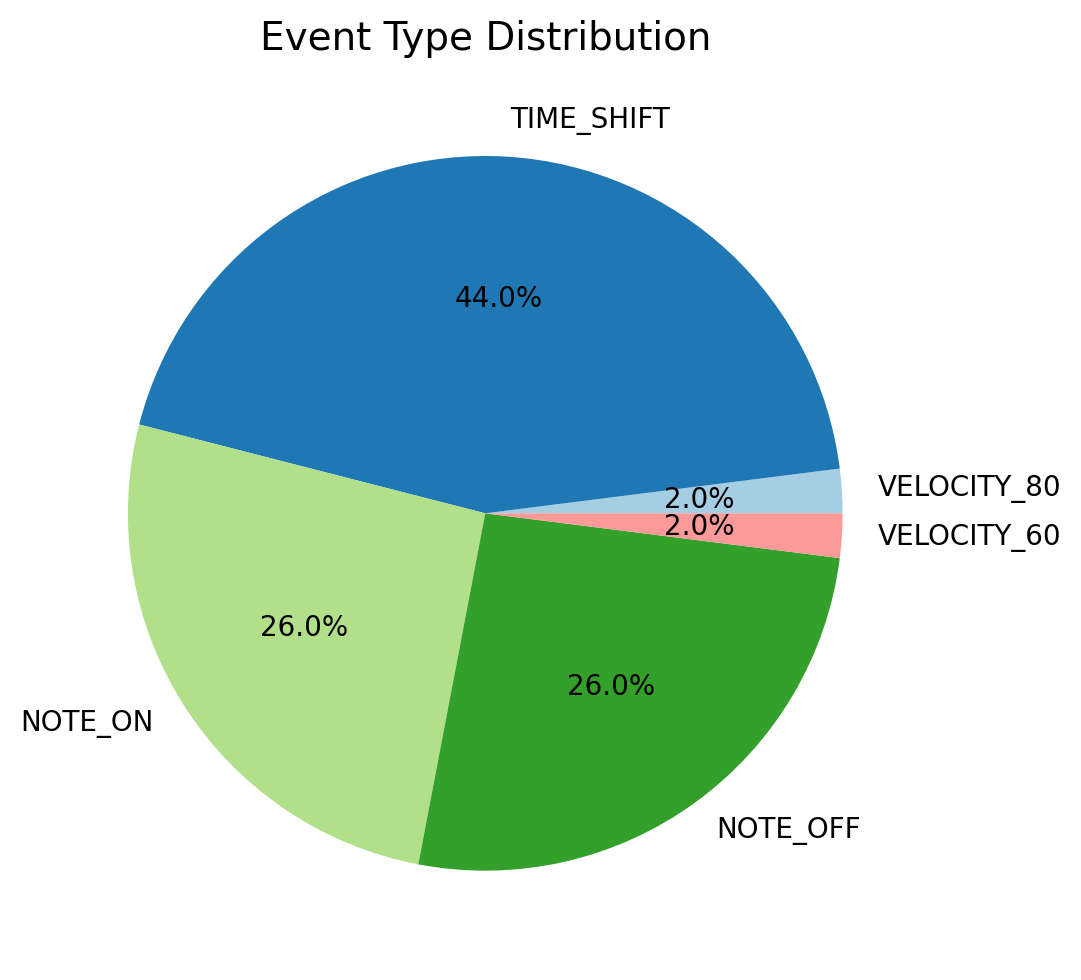

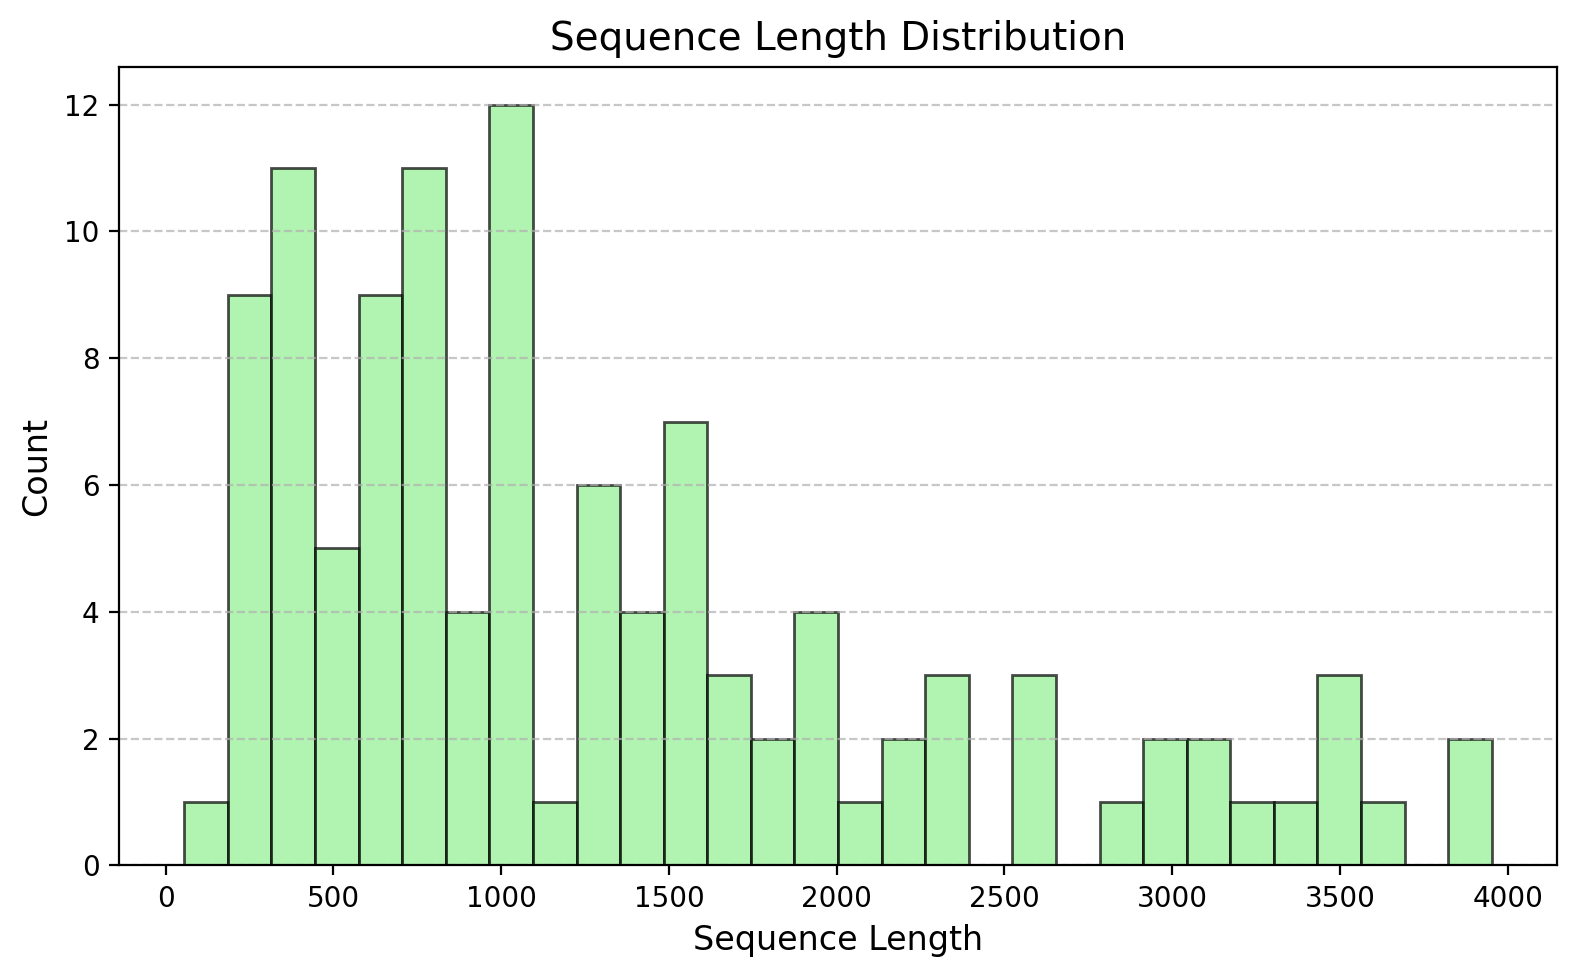

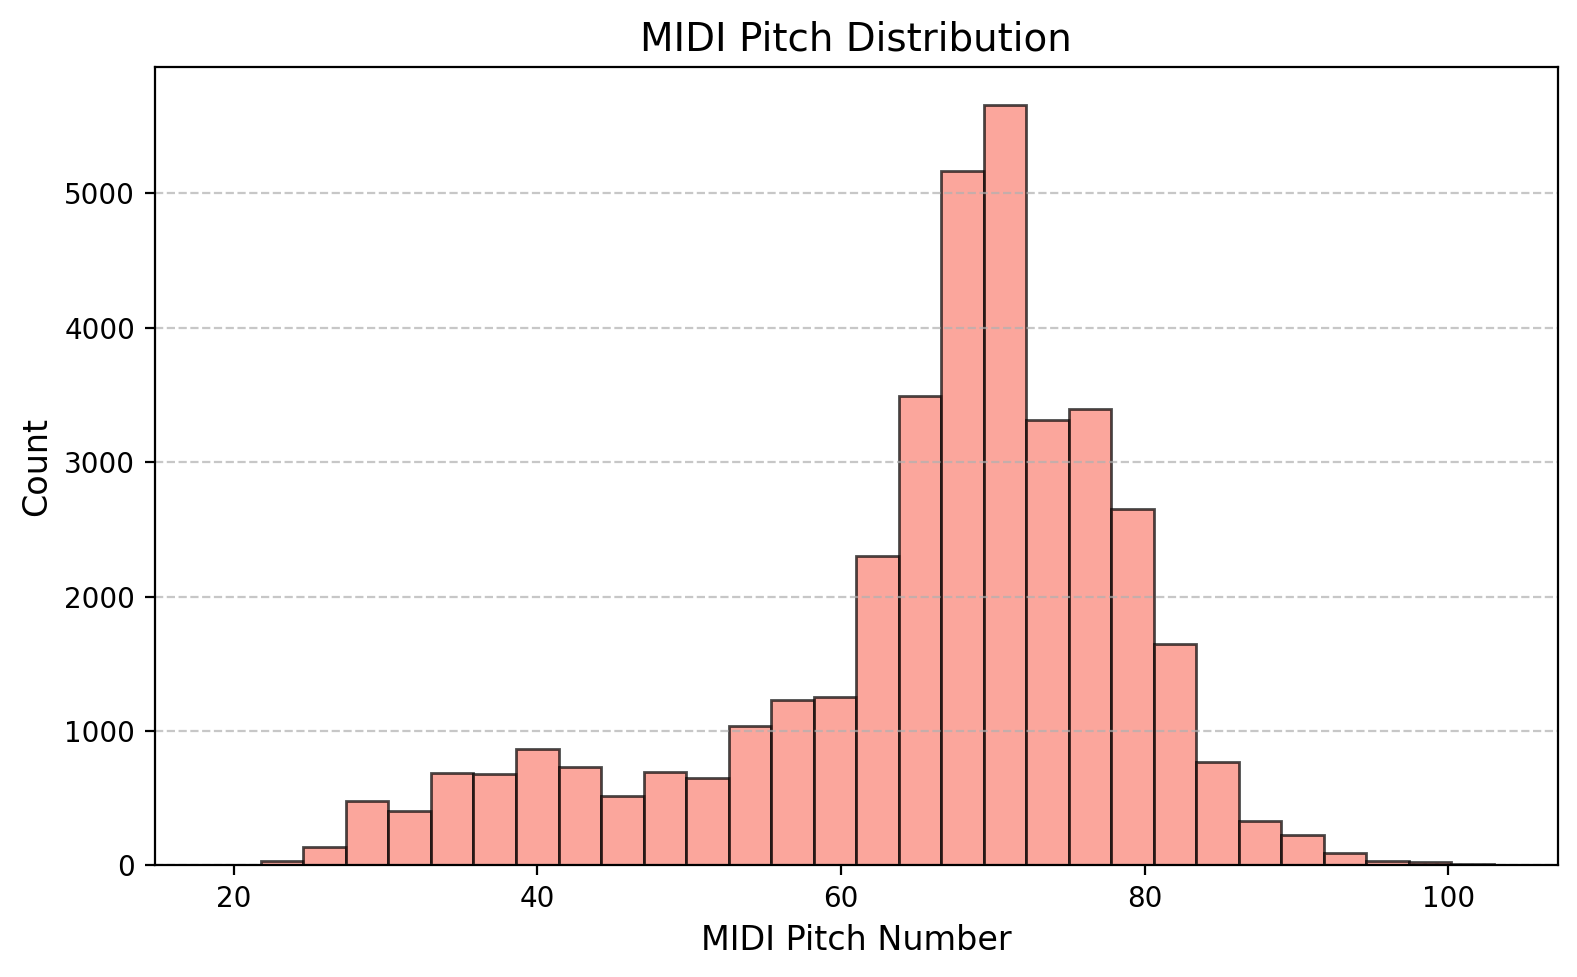

Plots saved to /content/drive/MyDrive/violin_plots


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os

# Create save directory
save_dir = '/content/drive/MyDrive/violin_plots'
os.makedirs(save_dir, exist_ok=True)

# 1. Event frequency distribution
plt.figure(figsize=(8, 5))
event_counts = Counter(all_events_flat)
top_events = event_counts.most_common(50)
event_indices, counts = zip(*top_events)
plt.bar(range(len(top_events)), counts, color='skyblue', edgecolor='black')
plt.title('Top 50 Most Frequent Events', fontsize=14)
plt.xlabel('Event Rank', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'event_frequency_distribution.png'), dpi=300)
plt.show()
plt.close()

# 2. Event type distribution
plt.figure(figsize=(8, 5))
event_type_counts = Counter([event_vocab[i].split('_')[0] + '_' + event_vocab[i].split('_')[1]
                             for i in event_indices])
plt.pie(event_type_counts.values(), labels=event_type_counts.keys(), autopct='%1.1f%%',
        colors=plt.cm.Paired(range(len(event_type_counts))), textprops={'fontsize': 10})
plt.title('Event Type Distribution', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'event_type_distribution.png'), dpi=300)
plt.show()
plt.close()

# 3. Sequence length distribution
plt.figure(figsize=(8, 5))
plt.hist(sequence_lengths, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title('Sequence Length Distribution', fontsize=14)
plt.xlabel('Sequence Length', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'sequence_length_distribution.png'), dpi=300)
plt.show()
plt.close()

# 4. MIDI pitch distribution
plt.figure(figsize=(8, 5))
note_on_events = [event for event in all_events_flat if event_vocab[event].startswith('NOTE_ON_')]
note_pitches_used = [int(event_vocab[event].split('_')[-1]) for event in note_on_events]
plt.hist(note_pitches_used, bins=30, alpha=0.7, color='salmon', edgecolor='black')
plt.title('MIDI Pitch Distribution', fontsize=14)
plt.xlabel('MIDI Pitch Number', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'midi_pitch_distribution.png'), dpi=300)
plt.show()
plt.close()

print(f"Plots saved to {save_dir}")

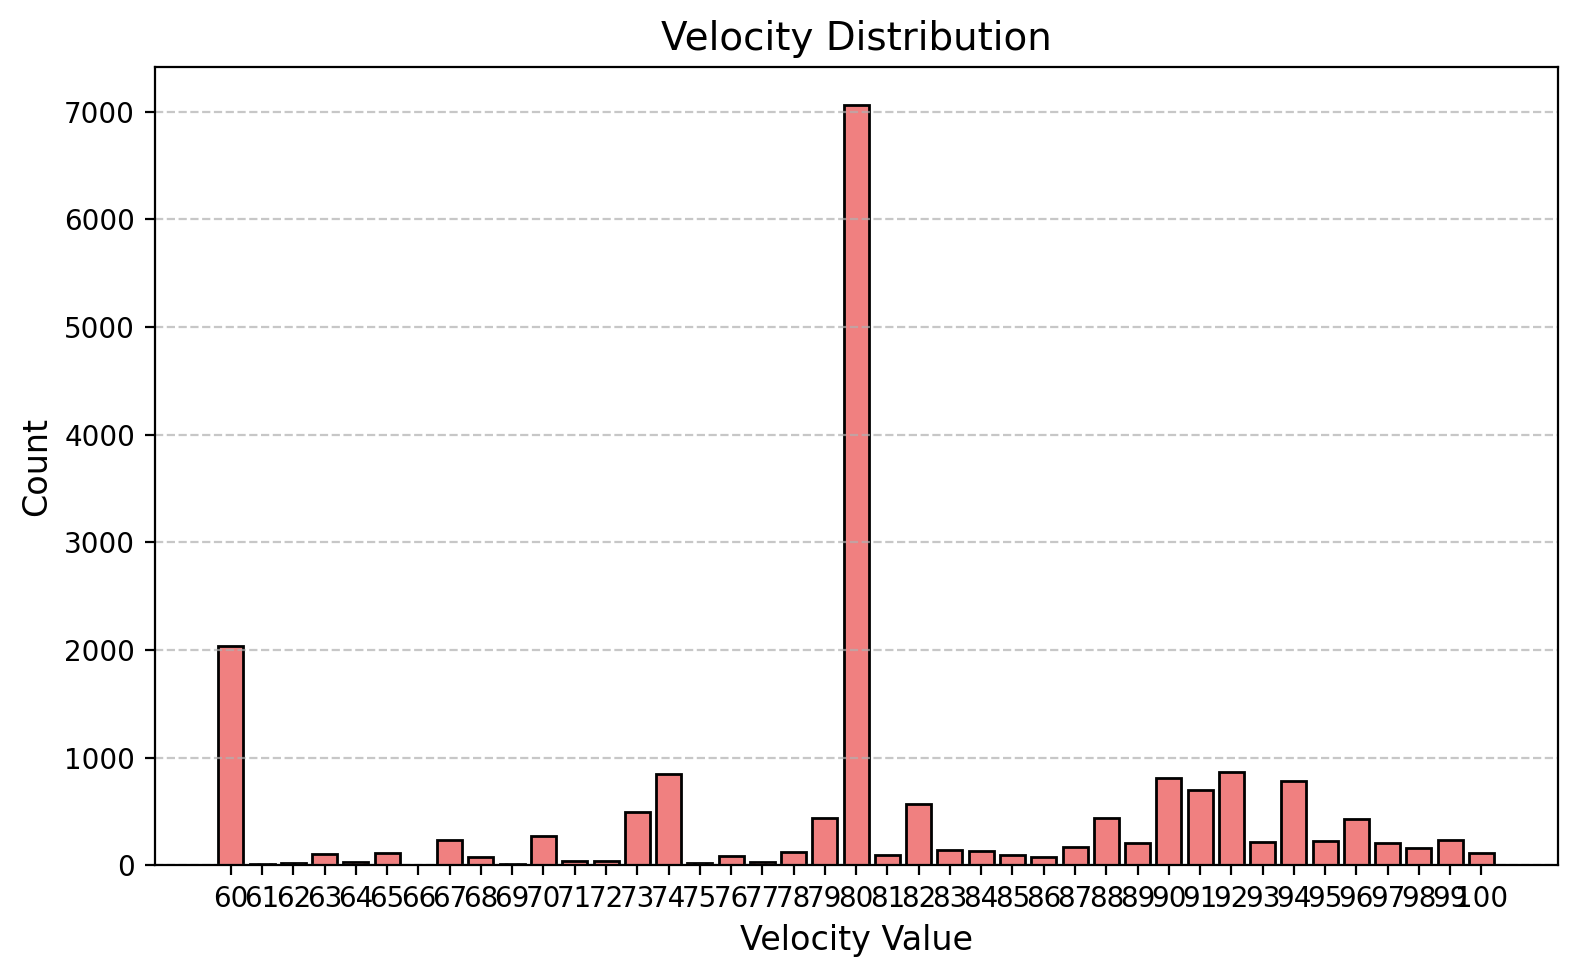

Velocity distribution plot saved to /content/drive/MyDrive/violin_plots/velocity_distribution.png


In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import os

# Ensure save directory exists
save_dir = '/content/drive/MyDrive/violin_plots'
os.makedirs(save_dir, exist_ok=True)

# Extract velocity events
velocity_events = [event for event in all_events_flat if event_vocab[event].startswith('VELOCITY_')]
velocity_values = [int(event_vocab[event].split('_')[-1]) for event in velocity_events]

# Plot velocity distribution
plt.figure(figsize=(8, 5))
velocity_counts = Counter(velocity_values)
velocities, counts = zip(*velocity_counts.most_common())  # Get all velocities, not just top N
plt.bar(velocities, counts, color='lightcoral', edgecolor='black')
plt.title('Velocity Distribution', fontsize=14)
plt.xlabel('Velocity Value', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(velocities, fontsize=10)  # Show all velocity values on x-axis
plt.yticks(fontsize=10)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'velocity_distribution.png'), dpi=300)
plt.show()
plt.close()

print(f"Velocity distribution plot saved to {save_dir}/velocity_distribution.png")

In [ ]:
class EventDataset(Dataset):
    """Dataset for sequence-to-sequence learning"""
    def __init__(self, sequences, seq_length=50):
        self.sequences = sequences
        self.seq_length = seq_length

    def __len__(self):
        return sum(max(0, len(seq) - self.seq_length) for seq in self.sequences)

    def __getitem__(self, idx):
        cum_len = 0
        for seq in self.sequences:
            seq_len = max(0, len(seq) - self.seq_length)
            if cum_len + seq_len > idx:
                start = idx - cum_len
                input_seq = seq[start:start + self.seq_length]
                target_seq = seq[start + 1:start + self.seq_length + 1]

                # Pad sequences if needed
                input_seq = input_seq + [0] * (self.seq_length - len(input_seq))
                target_seq = target_seq + [0] * (self.seq_length - len(target_seq))

                return (torch.tensor(input_seq, dtype=torch.long),
                        torch.tensor(target_seq, dtype=torch.long))
            cum_len += seq_len
        raise IndexError("Index out of range")

In [ ]:
class PerformanceRNN(nn.Module):
    """LSTM-based model for music generation"""
    def __init__(self, vocab_size, hidden_size=256, num_layers=3, dropout=0.3):
        super(PerformanceRNN, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, 128)
        self.lstm = nn.LSTM(128, hidden_size, num_layers,
                           batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = self.dropout(lstm_out)
        out = self.fc(lstm_out)
        return out, hidden

In [ ]:
random.shuffle(sequences)
split_idx = int(0.9 * len(sequences))
train_seqs = sequences[:split_idx]
test_seqs = sequences[split_idx:]

print(f"\nData split:")
print(f"Training sequences: {len(train_seqs)}")
print(f"Test sequences: {len(test_seqs)}")


Data split:
Training sequences: 99
Test sequences: 12


In [ ]:
dataset = EventDataset(train_seqs)
test_dataset = EventDataset(test_seqs)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"Training batches: {len(dataloader)}")
print(f"Test batches: {len(test_dataloader)}")

Training batches: 7970
Test batches: 851


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = PerformanceRNN(len(event_vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

Using device: cuda


In [ ]:
def train_model(model, dataloader, num_epochs=10):
    """Train the model"""
    model.train()
    losses = []

    print("\nTraining model...")
    for epoch in range(num_epochs):
        epoch_loss = 0
        batch_count = 0

        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs, _ = model(inputs)
            loss = criterion(outputs.view(-1, len(event_vocab)), targets.view(-1))
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_loss += loss.item()
            batch_count += 1

        avg_loss = epoch_loss / batch_count
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses, marker='o')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    return losses


Training model...
Epoch 1/10, Loss: 1.6190
Epoch 2/10, Loss: 0.8306
Epoch 3/10, Loss: 0.6586
Epoch 4/10, Loss: 0.5804
Epoch 5/10, Loss: 0.5371
Epoch 6/10, Loss: 0.5083
Epoch 7/10, Loss: 0.4881
Epoch 8/10, Loss: 0.4719
Epoch 9/10, Loss: 0.4596
Epoch 10/10, Loss: 0.4497


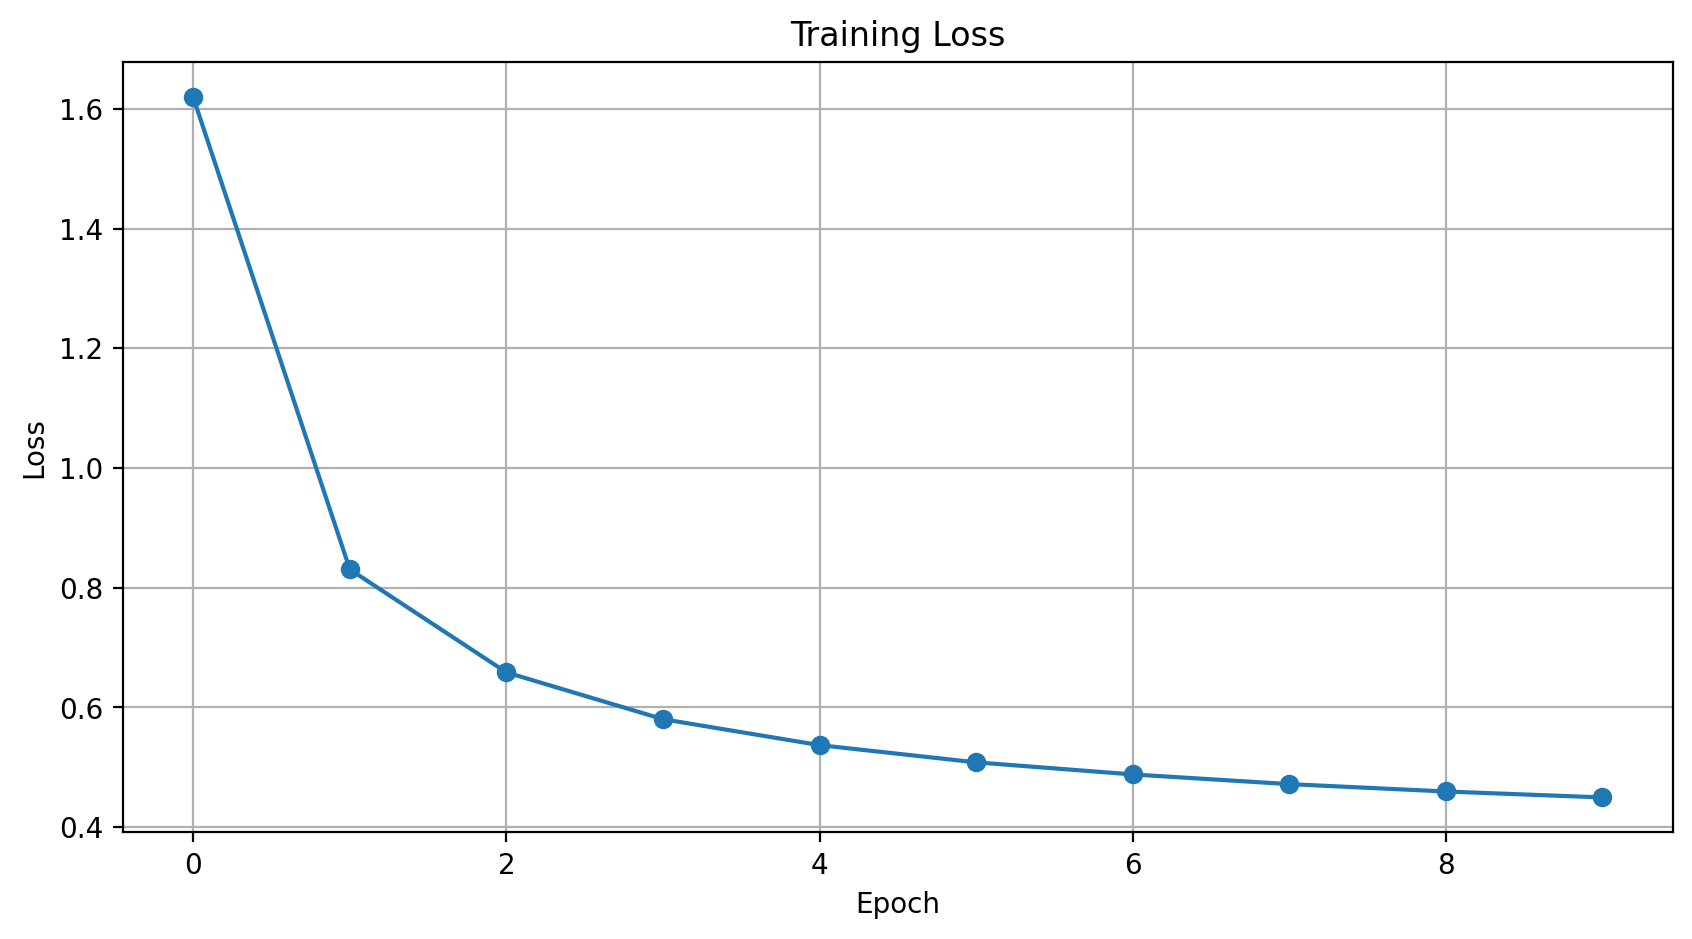

In [ ]:
train_losses = train_model(model, dataloader)

In [ ]:
def generate_events(model, seed_seq, length=200, temperature=1.0):
    """Generate events using the trained model"""
    model.eval()
    generated = seed_seq[:]

    with torch.no_grad():
        for _ in range(length - len(seed_seq)):
            # Use last 50 events as context
            context = generated[-50:]
            inputs = torch.tensor(context, dtype=torch.long).unsqueeze(0).to(device)

            outputs, _ = model(inputs)
            logits = outputs[0, -1] / temperature
            probs = torch.softmax(logits, dim=-1)
            next_event = torch.multinomial(probs, 1).item()
            generated.append(next_event)

    return generated

In [ ]:
def events_to_midi(events, event_vocab, filename):
    idx_to_event = {i: e for e, i in event_to_idx.items()}
    # Create a new NoteSequence
    sequence = note_seq.protobuf.music_pb2.NoteSequence()
    sequence.ticks_per_quarter = 220  # Standard MIDI resolution
    sequence.tempos.add(qpm=120)  # Default tempo: 120 BPM

    current_time = 0.0  # Time in seconds
    active_notes = {}  # Track active notes: {pitch: start_time}
    current_velocity = 100  # Default velocity

    for event_idx in events:
        event = idx_to_event[event_idx]
        if event.startswith("NOTE_ON_"):
            pitch = int(event.split("_")[-1])
            active_notes[pitch] = current_time
        elif event.startswith("NOTE_OFF_"):
            pitch = int(event.split("_")[-1])
            if pitch in active_notes:
                note = sequence.notes.add()
                note.start_time = active_notes[pitch]
                note.end_time = current_time
                note.pitch = pitch
                note.velocity = current_velocity
                note.instrument = 0
                note.program = 40  # Violin
                del active_notes[pitch]
        elif event.startswith("TIME_SHIFT_"):
            steps = int(event.split("_")[-1])
            current_time += steps * 0.01  # 0.01s per step (steps_per_second=100)
        elif event.startswith("VELOCITY_"):
            current_velocity = int(event.split("_")[-1])

    # Set total time of the sequence
    sequence.total_time = current_time

    # Convert NoteSequence to MIDI file
    note_seq.note_sequence_to_midi_file(sequence, filename)

In [ ]:
seed_seq = random.choice(train_seqs)[:10]
print(f"Using seed sequence of length {len(seed_seq)}")

generated_events = generate_events(model, seed_seq, length=400)
print(f"Generated sequence of length {len(generated_events)}")

success = events_to_midi(generated_events, event_vocab, OUTPUT_MIDI)

Using seed sequence of length 10
Generated sequence of length 400


In [ ]:
def compute_average_perplexity(model, test_dataloader, criterion, event_vocab_size):
    """
    Compute average perplexity across all test batches
    """
    model.eval()
    total_loss = 0
    total_tokens = 0
    num_batches = 0

    with torch.no_grad():
        for inputs, targets in test_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs, _ = model(inputs)

            # Calculate loss (ignore padding tokens with index 0)
            mask = targets != 0
            valid_targets = targets[mask]
            valid_outputs = outputs.view(-1, event_vocab_size)[mask.view(-1)]

            if len(valid_targets) > 0:
                loss = criterion(valid_outputs, valid_targets)
                total_loss += loss.item() * len(valid_targets)
                total_tokens += len(valid_targets)

            num_batches += 1

    if total_tokens == 0:
        return float('inf')

    avg_loss = total_loss / total_tokens
    perplexity = np.exp(avg_loss)

    print(f"Average perplexity calculation:")
    print(f"  Total batches processed: {num_batches}")
    print(f"  Total valid tokens: {total_tokens}")
    print(f"  Average loss: {avg_loss:.4f}")
    print(f"  Average perplexity: {perplexity:.2f}")

    return perplexity

In [ ]:
def generate_samples_at_temperatures(model, seed_seq, temperatures=[0.5, 0.8, 1.0, 1.2, 1.5],
                                   length=200, num_samples=1):
    """
    Generate music samples at different temperature values
    """
    model.eval()
    samples = {}

    print(f"Generating samples at different temperatures...")
    print(f"Seed sequence length: {len(seed_seq)}")
    print(f"Target generation length: {length}")

    for temp in temperatures:
        print(f"\nGenerating at temperature {temp}...")
        temp_samples = []

        for sample_idx in range(num_samples):
            generated = generate_events(model, seed_seq, length=length, temperature=temp)
            temp_samples.append(generated)

            # Calculate some basic statistics about the generated sequence
            unique_events = len(set(generated))
            repetition_rate = 1 - (unique_events / len(generated))

            print(f"  Sample {sample_idx + 1}: {len(generated)} events, "
                  f"{unique_events} unique, {repetition_rate:.3f} repetition rate")

        samples[temp] = temp_samples

    return samples

In [ ]:
def analyze_temperature_effects(samples, event_vocab, idx_to_event):
    """
    Analyze the effects of different temperatures on generated samples
    """
    print("\n=== TEMPERATURE ANALYSIS ===")

    analysis_results = {}

    for temp, temp_samples in samples.items():
        temp_stats = {
            'avg_unique_events': [],
            'avg_repetition_rate': [],
            'note_diversity': [],
            'time_shift_variance': []
        }

        for sample in temp_samples:
            # Basic diversity metrics
            unique_events = len(set(sample))
            repetition_rate = 1 - (unique_events / len(sample))
            temp_stats['avg_unique_events'].append(unique_events)
            temp_stats['avg_repetition_rate'].append(repetition_rate)

            # Convert indices back to events for analysis
            events = [idx_to_event[idx] for idx in sample if idx in idx_to_event]

            # Note diversity (unique pitches)
            note_events = [e for e in events if e.startswith('NOTE_ON_')]
            unique_pitches = len(set([int(e.split('_')[-1]) for e in note_events]))
            temp_stats['note_diversity'].append(unique_pitches)

            # Time shift variance
            time_events = [e for e in events if e.startswith('TIME_SHIFT_')]
            if time_events:
                time_values = [int(e.split('_')[-1]) for e in time_events]
                temp_stats['time_shift_variance'].append(np.var(time_values))
            else:
                temp_stats['time_shift_variance'].append(0)

        # Calculate averages
        analysis_results[temp] = {
            'avg_unique_events': np.mean(temp_stats['avg_unique_events']),
            'avg_repetition_rate': np.mean(temp_stats['avg_repetition_rate']),
            'avg_note_diversity': np.mean(temp_stats['note_diversity']),
            'avg_time_variance': np.mean(temp_stats['time_shift_variance'])
        }

        print(f"\nTemperature {temp}:")
        print(f"  Average unique events: {analysis_results[temp]['avg_unique_events']:.1f}")
        print(f"  Average repetition rate: {analysis_results[temp]['avg_repetition_rate']:.3f}")
        print(f"  Average note diversity: {analysis_results[temp]['avg_note_diversity']:.1f}")
        print(f"  Average time variance: {analysis_results[temp]['avg_time_variance']:.1f}")

    return analysis_results

In [ ]:
def save_temperature_samples(samples, event_vocab, base_filename="temp_sample"):
    """
    Save generated samples at different temperatures as MIDI files
    """
    saved_files = []

    for temp, temp_samples in samples.items():
        for i, sample in enumerate(temp_samples):
            filename = f"{base_filename}_temp{temp}_sample{i+1}.mid"
            try:
                events_to_midi(sample, event_vocab, filename)
                saved_files.append(filename)
                print(f"Saved: {filename}")
            except Exception as e:
                print(f"Error saving {filename}: {e}")

    return saved_files

In [ ]:
def save_temperature_samples(samples, event_vocab, base_filename="temp_sample"):
    """
    Save generated samples at different temperatures as MIDI files
    """
    saved_files = []

    for temp, temp_samples in samples.items():
        for i, sample in enumerate(temp_samples):
            filename = f"{base_filename}_temp{temp}_sample{i+1}.mid"
            try:
                events_to_midi(sample, event_vocab, filename)
                saved_files.append(filename)
                print(f"Saved: {filename}")
            except Exception as e:
                print(f"Error saving {filename}: {e}")

    return saved_files

def plot_temperature_analysis(analysis_results, save_dir):
    """
    Create visualization of temperature effects
    """
    temperatures = list(analysis_results.keys())

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Unique events
    unique_events = [analysis_results[t]['avg_unique_events'] for t in temperatures]
    axes[0, 0].plot(temperatures, unique_events, 'bo-', linewidth=2, markersize=8)
    axes[0, 0].set_title('Average Unique Events vs Temperature')
    axes[0, 0].set_xlabel('Temperature')
    axes[0, 0].set_ylabel('Unique Events')
    axes[0, 0].grid(True, alpha=0.3)

    # Repetition rate
    repetition_rates = [analysis_results[t]['avg_repetition_rate'] for t in temperatures]
    axes[0, 1].plot(temperatures, repetition_rates, 'ro-', linewidth=2, markersize=8)
    axes[0, 1].set_title('Average Repetition Rate vs Temperature')
    axes[0, 1].set_xlabel('Temperature')
    axes[0, 1].set_ylabel('Repetition Rate')
    axes[0, 1].grid(True, alpha=0.3)

    # Note diversity
    note_diversity = [analysis_results[t]['avg_note_diversity'] for t in temperatures]
    axes[1, 0].plot(temperatures, note_diversity, 'go-', linewidth=2, markersize=8)
    axes[1, 0].set_title('Average Note Diversity vs Temperature')
    axes[1, 0].set_xlabel('Temperature')
    axes[1, 0].set_ylabel('Unique Pitches')
    axes[1, 0].grid(True, alpha=0.3)

    # Time variance
    time_variance = [analysis_results[t]['avg_time_variance'] for t in temperatures]
    axes[1, 1].plot(temperatures, time_variance, 'mo-', linewidth=2, markersize=8)
    axes[1, 1].set_title('Average Time Shift Variance vs Temperature')
    axes[1, 1].set_xlabel('Temperature')
    axes[1, 1].set_ylabel('Time Variance')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()

    if save_dir:
        plt.savefig(os.path.join(save_dir, 'temperature_analysis.png'), dpi=300, bbox_inches='tight')

    plt.show()

In [ ]:
avg_test_perplexity = compute_average_perplexity(model, test_dataloader, criterion, len(event_vocab))

Average perplexity calculation:
  Total batches processed: 851
  Total valid tokens: 680550
  Average loss: 5.2773
  Average perplexity: 195.83


In [ ]:
small_train_dataset = EventDataset(train_seqs[:len(test_seqs)])  # Same size as test set
small_train_dataloader = DataLoader(small_train_dataset, batch_size=16, shuffle=False)
avg_train_perplexity = compute_average_perplexity(model, small_train_dataloader, criterion, len(event_vocab))

Average perplexity calculation:
  Total batches processed: 1030
  Total valid tokens: 823600
  Average loss: 0.2637
  Average perplexity: 1.30


In [ ]:
seed_seq = random.choice(train_seqs)[:10]  # Use same seed for all temperatures
idx_to_event = {i: e for e, i in event_to_idx.items()}

# Generate samples at different temperatures
temperature_samples = generate_samples_at_temperatures(
    model, seed_seq,
    temperatures=[0.3, 0.6, 0.8, 1.0, 1.2, 1.5, 2.0],
    length=300,
    num_samples=2
)

Generating samples at different temperatures...
Seed sequence length: 10
Target generation length: 300

Generating at temperature 0.3...
  Sample 1: 300 events, 50 unique, 0.833 repetition rate
  Sample 2: 300 events, 42 unique, 0.860 repetition rate

Generating at temperature 0.6...
  Sample 1: 300 events, 42 unique, 0.860 repetition rate
  Sample 2: 300 events, 46 unique, 0.847 repetition rate

Generating at temperature 0.8...
  Sample 1: 300 events, 58 unique, 0.807 repetition rate
  Sample 2: 300 events, 45 unique, 0.850 repetition rate

Generating at temperature 1.0...
  Sample 1: 300 events, 62 unique, 0.793 repetition rate
  Sample 2: 300 events, 45 unique, 0.850 repetition rate

Generating at temperature 1.2...
  Sample 1: 300 events, 75 unique, 0.750 repetition rate
  Sample 2: 300 events, 57 unique, 0.810 repetition rate

Generating at temperature 1.5...
  Sample 1: 300 events, 83 unique, 0.723 repetition rate
  Sample 2: 300 events, 113 unique, 0.623 repetition rate

Generat

In [ ]:
temp_analysis = analyze_temperature_effects(temperature_samples, event_vocab, idx_to_event)


=== TEMPERATURE ANALYSIS ===

Temperature 0.3:
  Average unique events: 46.0
  Average repetition rate: 0.847
  Average note diversity: 7.5
  Average time variance: 768.8

Temperature 0.6:
  Average unique events: 44.0
  Average repetition rate: 0.853
  Average note diversity: 9.0
  Average time variance: 768.5

Temperature 0.8:
  Average unique events: 51.5
  Average repetition rate: 0.828
  Average note diversity: 8.5
  Average time variance: 1714.0

Temperature 1.0:
  Average unique events: 53.5
  Average repetition rate: 0.822
  Average note diversity: 9.0
  Average time variance: 1058.0

Temperature 1.2:
  Average unique events: 66.0
  Average repetition rate: 0.780
  Average note diversity: 20.5
  Average time variance: 828.5

Temperature 1.5:
  Average unique events: 98.0
  Average repetition rate: 0.673
  Average note diversity: 23.5
  Average time variance: 1677.5

Temperature 2.0:
  Average unique events: 144.0
  Average repetition rate: 0.520
  Average note diversity: 33.5


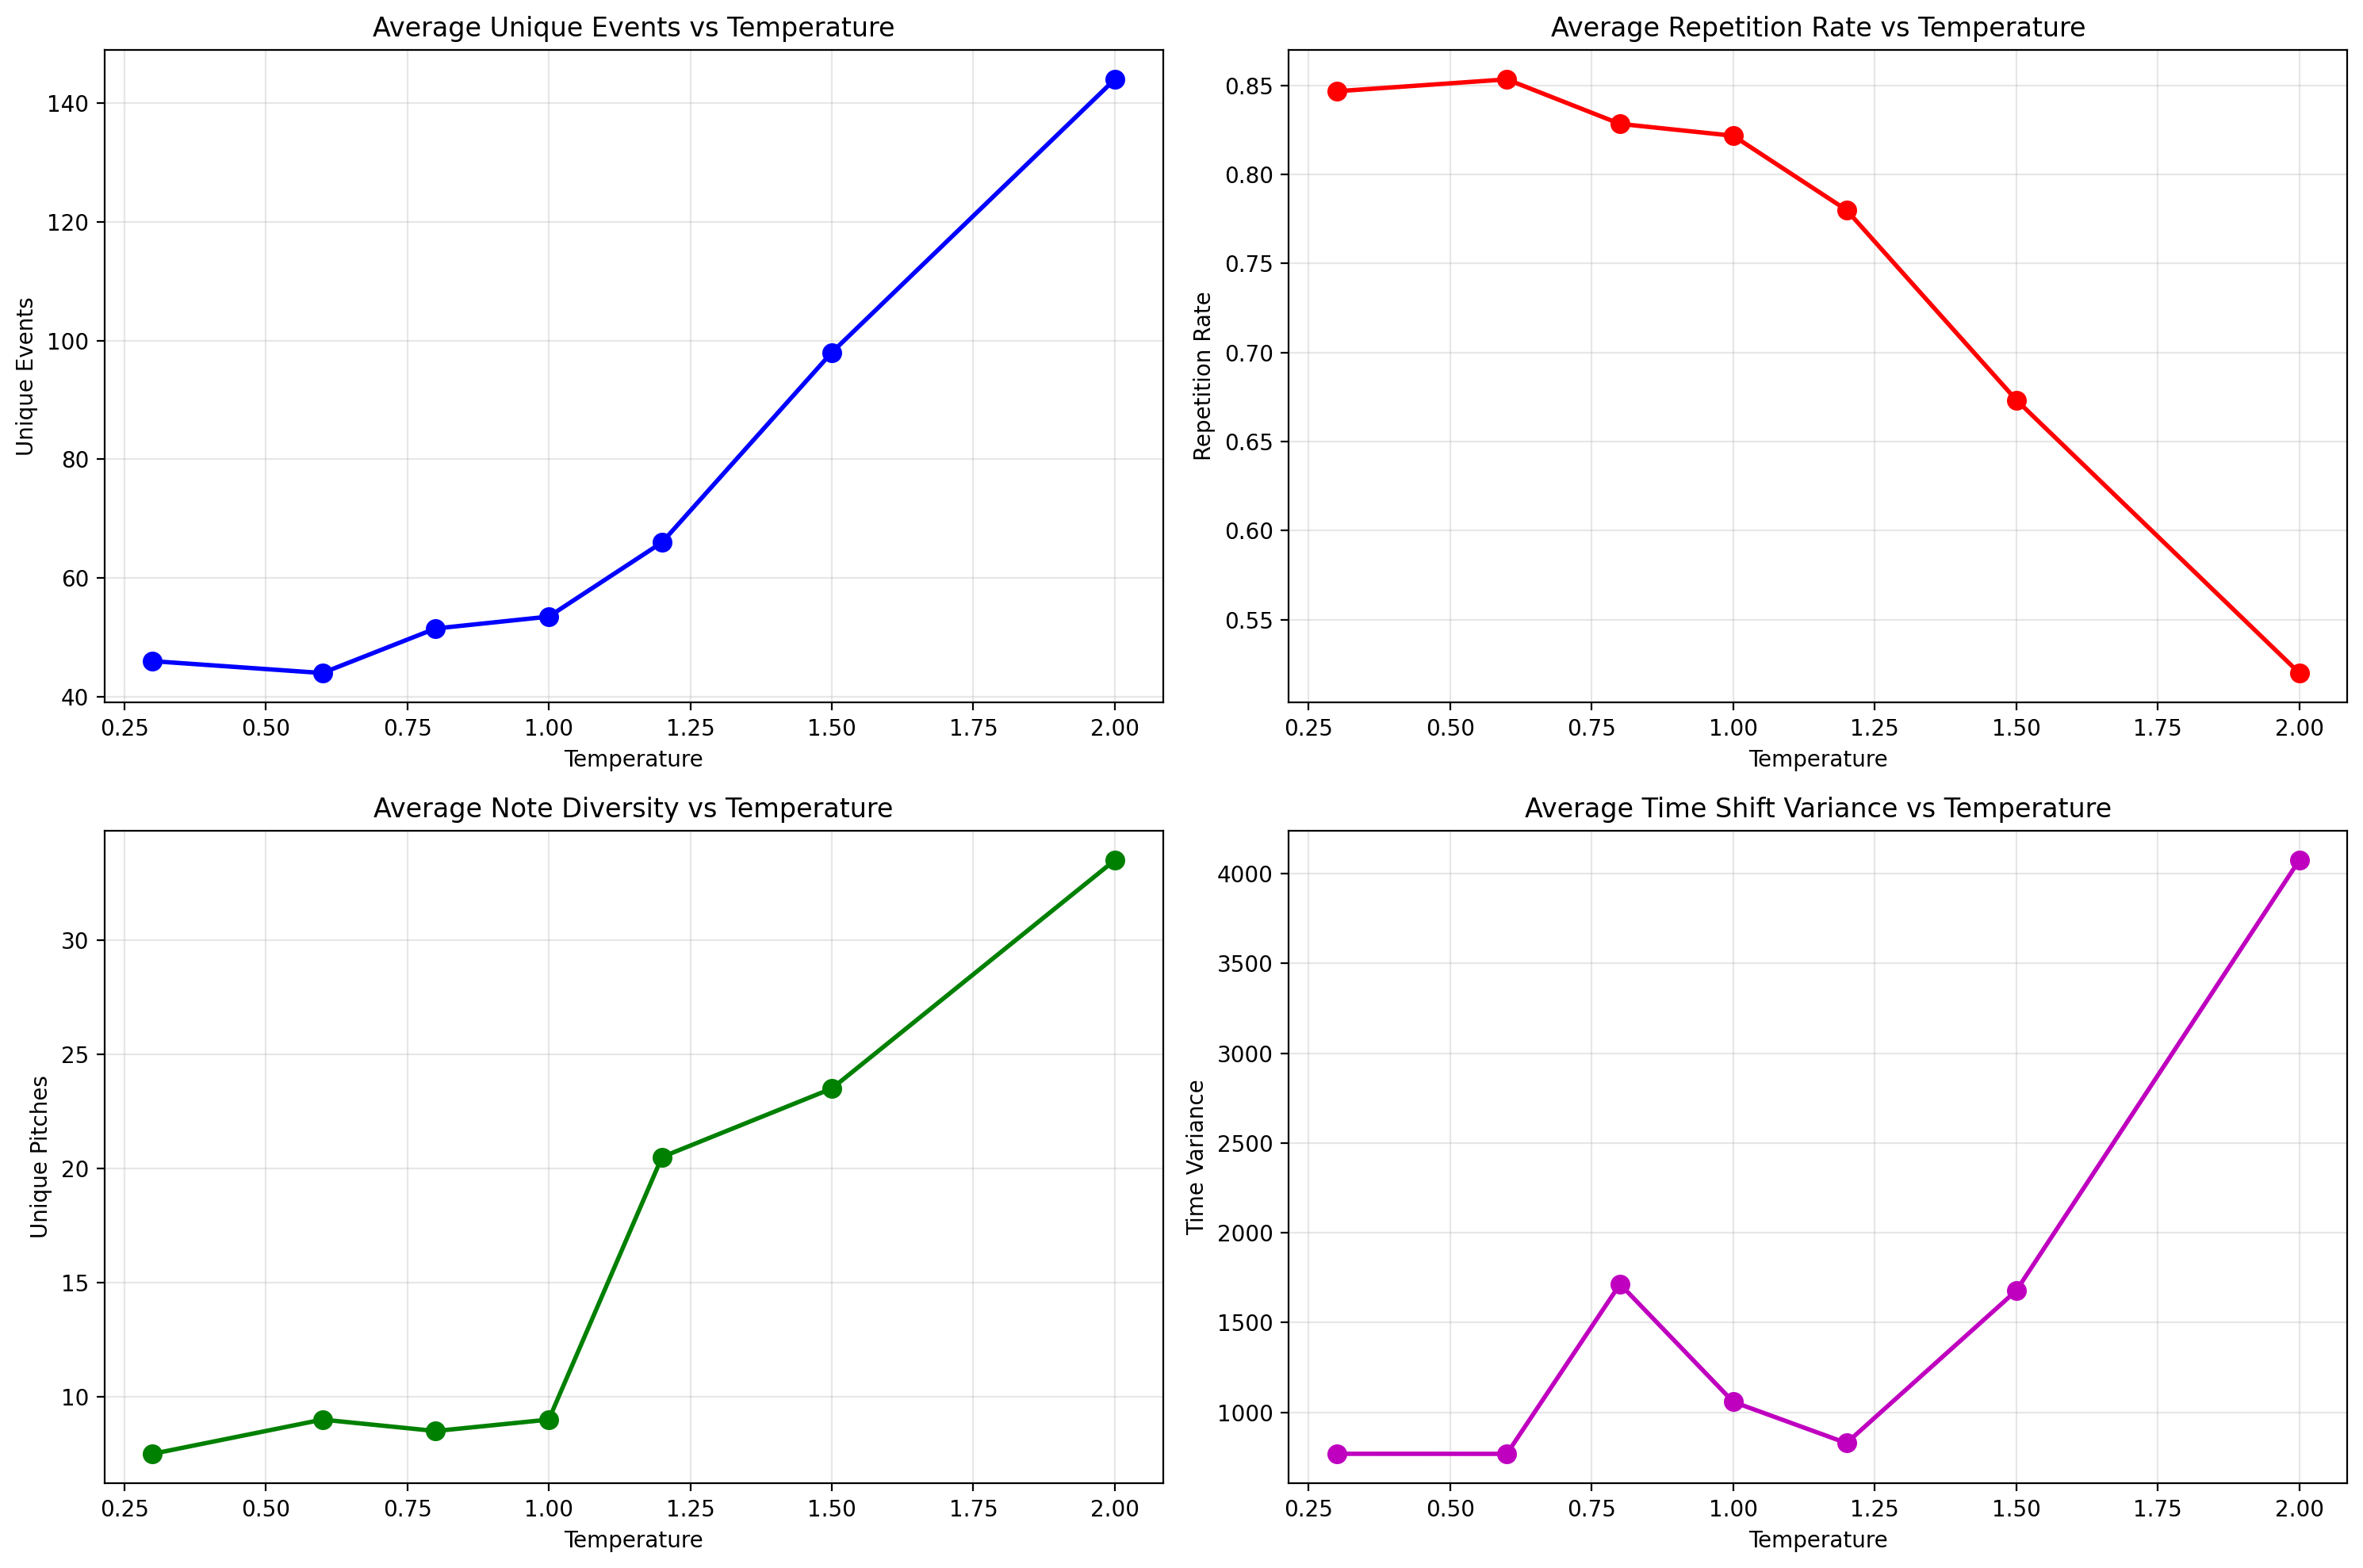

In [ ]:
plot_temperature_analysis(temp_analysis, save_dir)

In [ ]:
saved_files = save_temperature_samples(temperature_samples, event_vocab)

Saved: temp_sample_temp0.3_sample1.mid
Saved: temp_sample_temp0.3_sample2.mid
Saved: temp_sample_temp0.6_sample1.mid
Saved: temp_sample_temp0.6_sample2.mid
Saved: temp_sample_temp0.8_sample1.mid
Saved: temp_sample_temp0.8_sample2.mid
Saved: temp_sample_temp1.0_sample1.mid
Saved: temp_sample_temp1.0_sample2.mid
Saved: temp_sample_temp1.2_sample1.mid
Saved: temp_sample_temp1.2_sample2.mid
Saved: temp_sample_temp1.5_sample1.mid
Saved: temp_sample_temp1.5_sample2.mid
Saved: temp_sample_temp2.0_sample1.mid
Saved: temp_sample_temp2.0_sample2.mid


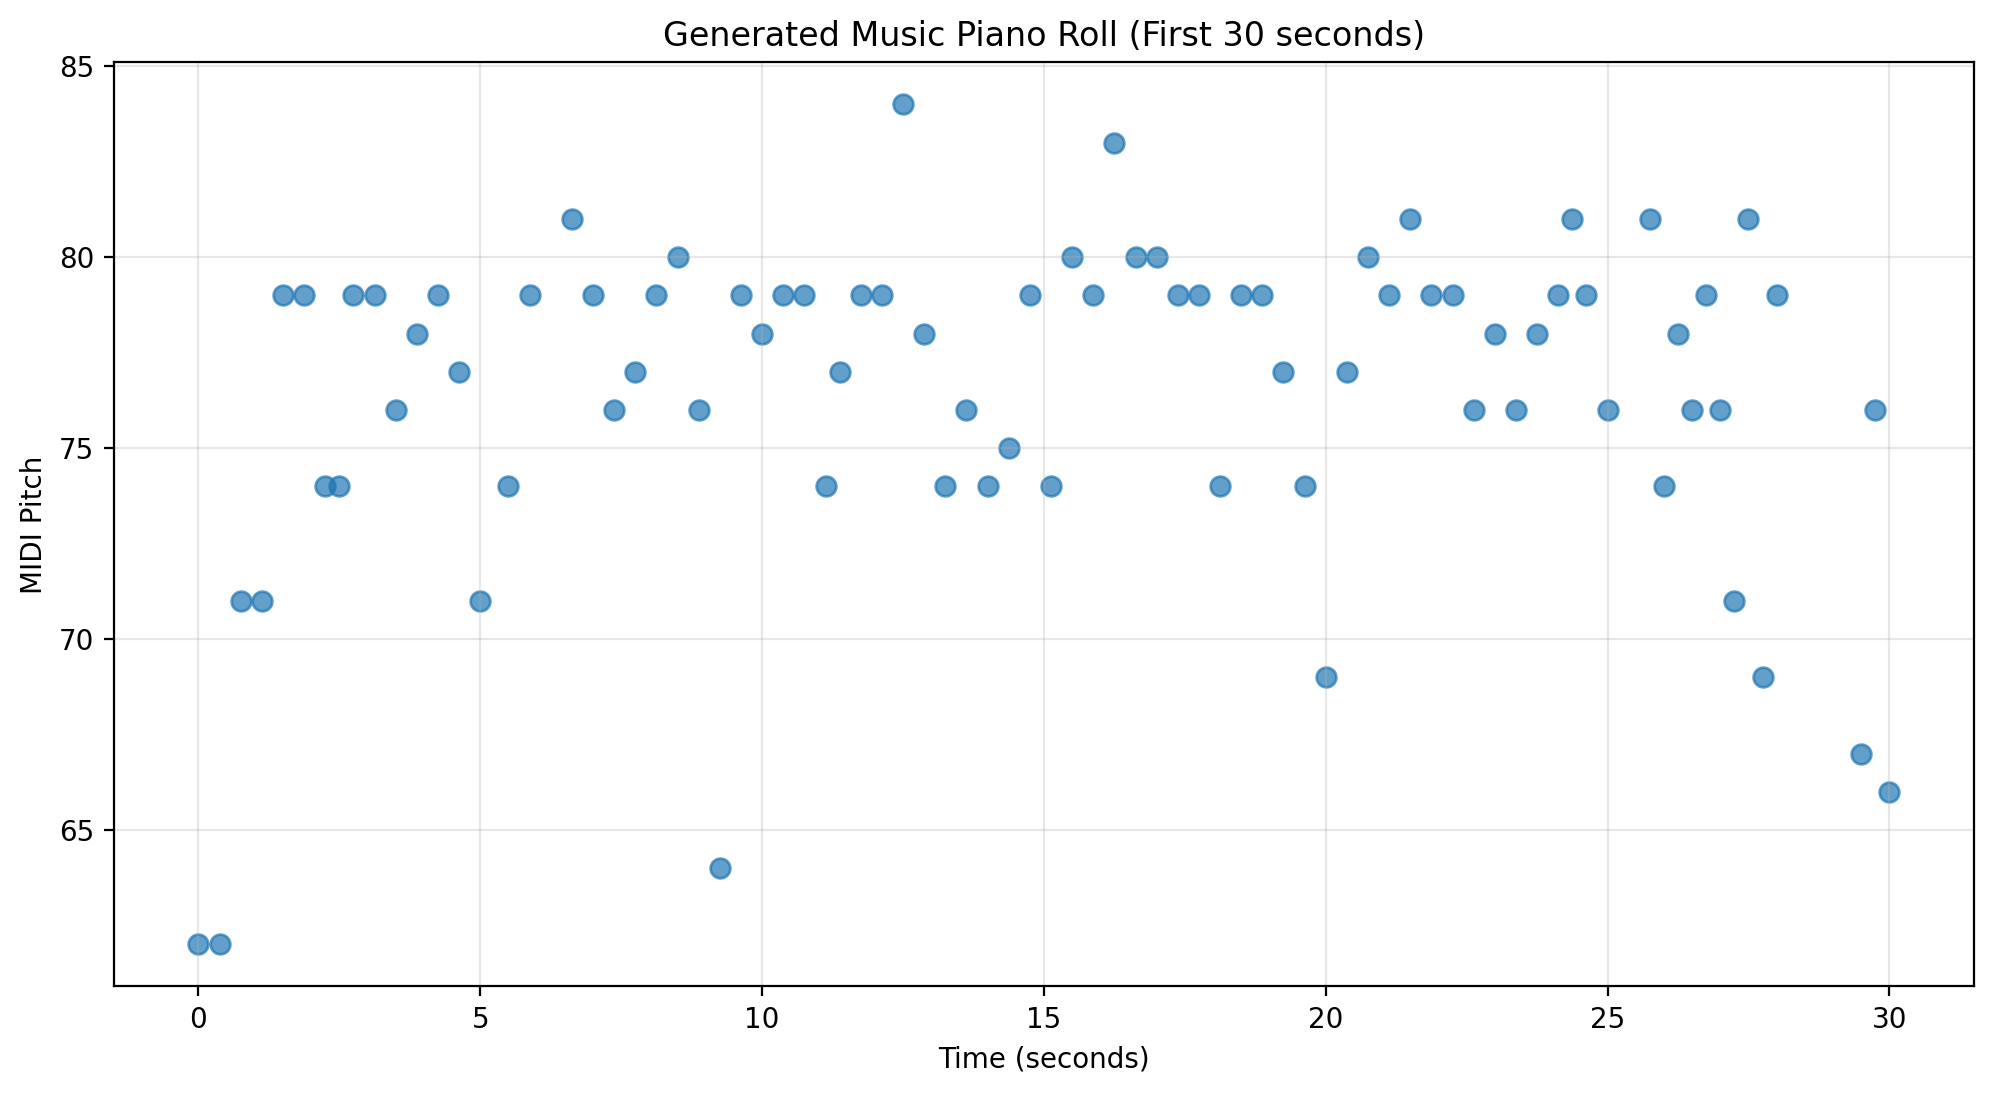

In [ ]:
# Download the generated file
from google.colab import files
files.download(OUTPUT_MIDI)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>